# Week 8 - Conversation and Text Generation
Many natural language activities boil down to text generation, especially the back-and-forth nature of natural conversation and question answering. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.


Much recent NLP research is on text generation. Before the phenomenal product ChatGPT (OpenAI) was released at the end of 2022,  this is the primary use of large language models like GPT-3/4 (OpenAI), Wu Dao (Beijing Academy of AI), and Gopher (DeepMind). Then everything went wild in 2023. We saw tons of open-sourced LLMs were released like the Llama series (Meta), and how others techs wanted to compete with OpenAI by releasing models like Claude (Anthropic), Bard (Google), Gemini (Google x2), etc. The success of these models have prompted debate over whether the risks and perils of artificial general intelligence (AGI) is approaching!

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
# !pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import seaborn as sns
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os
import io
import zipfile

import networkx as nx

%matplotlib inline

import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange

c:\Users\flori\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline

In [3]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

# ConvoKit
As we alluded to in Week 7 with causal inference, [ConvoKit](https://convokit.cornell.edu/) is an exciting platform for conversational analysis developed by Jonathan Chang, Calem Chiam, and others, mostly at Cornell. Keep this in mind if you are interested in a final project with conversational data such as Twitter threads or movie scripts. They have an [interactive tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), which we include some examples from below. Most of the following text and code is authored by them.

These ConvoKit corpora can be used for the next exercise in this notebook.

In [4]:
try:
    import convokit
except ModuleNotFoundError:
    !pip install convokit


     -------------------------------------- 183.2/183.2 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 57.6/57.6 kB ? eta 0:00:00
     ------------------------------------- 175.4/175.4 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 307.7/307.7 kB 9.3 MB/s eta 0:00:00
   ---------------------------------------- 472.8/472.8 kB 7.5 MB/s eta 0:00:00
   ---------------------------------------- 78.3/78.3 kB 4.3 MB/s et

In [5]:
# for pretty printing of cells within the Colab version of this notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [6]:
import convokit
from convokit import Corpus, download

### Loading a Corpus

A Corpus represents a conversational dataset. We typically begin our analysis by loading a Corpus. A list of existing datasets already in ConvoKit format can be found [here](https://convokit.cornell.edu/documentation/datasets.html).

A growing list of many other conversational datasets covering a variety of conversational settings are available in ConvoKit, such as face-to-face (e.g. the [*Intelligence Squared Debates corpus*](https://convokit.cornell.edu/documentation/iq2.html)), institutional (e.g. the [*Supreme Court Oral Arguments corpus*](https://convokit.cornell.edu/documentation/supreme.html)), fictional (e.g. the [*Cornell Movie Dialog Corpus*](https://convokit.cornell.edu/documentation/movie.html)), or online  (e.g. all talkpage conversations on [*Wikipedia Talk Pages*](https://convokit.cornell.edu/documentation/wiki.html) and a full dump of [*Reddit*](https://convokit.cornell.edu/documentation/subreddit.html)).

For this tutorial, we will primarily be using the *r/Cornell* subreddit corpus to demo various ConvoKit functionality, and occasionally the [*Switchboard Dialog Act Corpus*](https://convokit.cornell.edu/documentation/switchboard.html) (a collection of anonymized five-minute telephone conversations) as a contrasting dataset.

In [ ]:
corpus = Corpus(download('subreddit-Cornell'))

# You can try a different corpus if you want.
#corpus = Corpus(download('diplomacy-corpus'))
#corpus = Corpus(download('switchboard-corpus'))
#corpus = Corpus(download('reddit-corpus-small'))

No configuration file found at /root/.convokit/config.yml; writing with contents: 
# Default Backend Parameters
db_host: localhost:27017
data_directory: ~/.convokit/saved-corpora
default_backend: mem


In [ ]:
corpus.print_summary_stats()

Number of Speakers: 7568
Number of Utterances: 74467
Number of Conversations: 10744


### Corpus components: Conversations, Utterances, Speakers

Every Corpus has three main components: [Conversations](https://convokit.cornell.edu/documentation/conversation.html), [Utterances](https://convokit.cornell.edu/documentation/utterance.html), and [Speakers](https://convokit.cornell.edu/documentation/speaker.html). Just as in real life, in ConvoKit, Conversations are some sequence of Utterances, where each Utterance is made by some Speaker. Let's look at an example of each.

In [ ]:
# This is a Reddit thread
corpus.random_conversation().meta

ConvoKitMeta({'title': 'Cornell Refuses Gift from Renowned Architect Alumnus After 5 Women Say He Sexually Harassed Them', 'num_comments': 8, 'domain': 'cornellsun.com', 'timestamp': 1521000158, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''})

In [ ]:
# This is a Reddit post or comment.
corpus.random_utterance().meta

ConvoKitMeta({'score': 1, 'top_level_comment': 'di08apt', 'retrieved_on': 1496811338, 'gilded': 0, 'gildings': None, 'subreddit': 'Cornell', 'stickied': False, 'permalink': '', 'author_flair_text': '2020'})

In [ ]:
# The r/Cornell Corpus does not have speaker metadata.
#corpus.random_speaker().meta

#Speaker do have an 'id' which is their Reddit username, as seen here.
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7b18f4e8a3e0>, 'id': 'Important_Lettuce', 'meta': ConvoKitMeta({})})

In [ ]:
# We can iterate through these objects as we iterate lists or DataFrames in Python.
for utt in corpus.iter_utterances():
    print(utt.text)
    break

I was just reading about the Princeton Mic-Check and it's getting [national press](http://www.bloomberg.com/news/2011-12-29/princeton-brews-trouble-for-us-1-percenters-commentary-by-michael-lewis.html).

I want to get a sense of what people felt like around campus. Anything interesting happen? Anything interesting coming up?


Conversations, Utterances, and Speakers are each interesting, but the magic of conversational analysis is connecting them. For example, we can get all the Conversations in which a Speaker has participated and all the Utterances they have made. To make it more interesting, we can find a Speaker to study by navigating from a random Utterance.

In [ ]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7b18f4e8a3e0>, 'id': 'e27y8', 'meta': ConvoKitMeta({'title': '"For small creatures such as we the vastness is bearable only through love." Happy Carl Sagan Day!', 'num_comments': 1, 'domain': 'youtube.com', 'timestamp': 1289070151, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''})}),
 Conversation({'obj_type': 'conversation', 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7b18f4e8a3e0>, 'id': 'e3v2z', 'meta': ConvoKitMeta({'title': 'Cornell University Lab Releases Powerful New Evidence that the Human Mind can Perceive the Future', 'num_comments': 1, 'domain': 'hplusmagazine.com', 'timestamp': 1289364274, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''})}),
 Conversation({'obj_type': 'conversation', 'vectors': [], 'tree': None, 'owner'

For a more qualitative feel of the data, you can display a Conversation. For Reddit data, this is a single thread.

In [ ]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")



    Holy crap.  I only glanced at the abstract of the paper, but it says p-value = 1



There is a lot more to ConvoKit that we encourage you to explore, especially their [tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), but the ability to seamlessly navigate between the Utterances, Conversations, and Speakers of a Corpus is extremely valuable for social science.

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that use ConvoKit to analyze a Corpus other than 'subreddit-Cornell', including at least one function you find in the package not used above. You can also generate a ConvoKit Corpus from your own dataset based on [their Corpus from .txt files tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) or [their Corpus from pandas tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/corpus_from_pandas.ipynb), but that may be time-consuming for a weekly assignment. (It could be a great idea for your final project!)

My dataset does not contain valuable conversation data, using convokit dataset movie-corpus instead.

In [7]:
from convokit import Corpus, download

# Load an example corpus from ConvoKit
corpus = Corpus(filename=download("movie-corpus"))

No configuration file found at C:\Users\flori/.convokit/config.yml; writing with contents: 
# Default Backend Parameters
db_host: localhost:27017
data_directory: ~/.convokit/saved-corpora
default_backend: mem


In [8]:
# Get metadata of a random conversation
random_convo_meta = corpus.random_conversation().meta
print("Random Conversation Metadata:", random_convo_meta)


Random Conversation Metadata: ConvoKitMeta({'movie_idx': 'm451', 'movie_name': 'my girl', 'release_year': '1991', 'rating': '6.40', 'votes': '17967', 'genre': "['comedy', 'drama', 'family', 'romance']"})


In [9]:
# Get a random utterance and its metadata
utt = corpus.random_utterance()
print("Random Utterance:", utt.text)
print("Random Utterance Metadata:", utt.meta)

Random Utterance: And we want you to know, Sal, that any help you might need--
Random Utterance Metadata: ConvoKitMeta({'movie_id': 'm320', 'parsed': [{'rt': 2, 'toks': [{'tok': 'And', 'tag': 'CC', 'dep': 'cc', 'up': 2, 'dn': []}, {'tok': 'we', 'tag': 'PRP', 'dep': 'nsubj', 'up': 2, 'dn': []}, {'tok': 'want', 'tag': 'VBP', 'dep': 'ROOT', 'dn': [0, 1, 5]}, {'tok': 'you', 'tag': 'PRP', 'dep': 'nsubj', 'up': 5, 'dn': []}, {'tok': 'to', 'tag': 'TO', 'dep': 'aux', 'up': 5, 'dn': []}, {'tok': 'know', 'tag': 'VB', 'dep': 'ccomp', 'up': 2, 'dn': [3, 4, 6, 7, 8, 11]}, {'tok': ',', 'tag': ',', 'dep': 'punct', 'up': 5, 'dn': []}, {'tok': 'Sal', 'tag': 'NNP', 'dep': 'dobj', 'up': 5, 'dn': []}, {'tok': ',', 'tag': ',', 'dep': 'punct', 'up': 5, 'dn': []}, {'tok': 'that', 'tag': 'IN', 'dep': 'mark', 'up': 11, 'dn': []}, {'tok': 'any', 'tag': 'DT', 'dep': 'det', 'up': 11, 'dn': []}, {'tok': 'help', 'tag': 'NN', 'dep': 'dobj', 'up': 5, 'dn': [9, 10, 13, 14]}, {'tok': 'you', 'tag': 'PRP', 'dep': 'nsubj'

In [11]:
# Display the structure of a conversation
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

And we want you to know, Sal, that any help you might need--

    Yeah, Sal--



In [12]:
# Calculate and display metrics for a random speaker
from convokit import Speaker

spkr: Speaker = corpus.random_speaker()
print(f"Speaker ID: {spkr.id}")
print("Speaker Metrics:", spkr.meta)


Speaker ID: u5082
Speaker Metrics: ConvoKitMeta({'character_name': 'MANDY', 'movie_idx': 'm336', 'movie_name': 'erin brockovich', 'gender': '?', 'credit_pos': '?'})


## Creating networks of agents from corpora

Now let's return to the Davies corpora (specifically, Soap Operas) to see how we can extract actors and build a network of their relationships in the texts.

We'll use the `lucem_illud.loadDavies()` function to get the dataframe. Make sure to download `SOAP.zip` from DropBox, unzip, and edit the following line with the path to that file. This code may take some time.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
corpora_address = "C:/Users/flori/OneDrive/Desktop/UCHICAGO/NLP/Comutational Content Analysis/CCA_NLP/Homework-Notebooks-2023/data/SOAP"

In [14]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_0-tez.zip
text_1-teh.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_5-rag.zip
text_6-egn.zip
text_7-jss.zip
text_8-sbo.zip
text_9-jtw.zip


We now use the source to see how the data is stored. Note that this is different from the movies corpus, and that we will need to use a different aggregating method to store the data. Each dataset would have a different approach, but they are all very similar, it depends on how the data is stored. Here multiple textids match multiple scripts, so our soap dataframe would be structured a little differently.

You can see the first 20 lines of the source file here.

In [15]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [16]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [17]:
source[0:20]

[b'textID\tyear\tshow\t\turl\r\n',
 b'-----\t-----\t-----\t\t-----\r\n',
 b'\r\n',
 b'1\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-04-09-01.shtml\r\n',
 b'2\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-05-09-01.shtml\r\n',
 b'3\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-06-20-01.shtml\r\n',
 b'4\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-07-01.shtml\r\n',
 b'5\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-08-01.shtml\r\n',
 b'6\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-09-01.shtml\r\n',
 b'7\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-10-01.shtml\r\n',
 b'8\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-13-01.shtml\r\n',
 b'9\t2001\tAll My Childen\thttp://tvmegasite.net/tra

In [18]:
soap_dict = {}

In [19]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [20]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [21]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [22]:
i = 0

In [23]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [24]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Liza, You, 're, in, early, @!Ryan, Yeah, I,..."
1,As the World Turns,"[@!Katie, Simon, where, are, you, @!Simon, Kat..."
2,Bold and Beautiful,"[@!Morgan, What, 's, the, matter, Stephanie, Y..."
3,Days of Our Lives,"[@!Philip, Seems, like, every, time, I, look, ..."
4,General Hospital,"[@!Stefan, I, love, her, @!Jax, No, Cassadine,..."
5,Guiding Light,"[@!Reva, Well, it, 's, very, peaceful, Your, b..."
6,One Life to Live,"[@!Rae, What, She, even, has, a, new, friend, ..."
7,Passions,"[@!Kay, Going, to, get, pregnant, and, I, 'm, ..."
8,Port Charles,"[@!Jack, There, you, are, you, son, @!Chris, H..."
9,Young and Restless,"[@!Sharon, Yeah, I, could, n't, sleep, @!Victo..."


We now have each Soap, and each of the Tokenized texts. Let us see what kind of information we can get. These are American soap operas, and are likely to be cheesy and dramatic (an understatment). A fun start would be to make networks of each of the actors and actresses in these soaps.

What would be a good way to create a network? Maybe everytime someone talks to someone we add one weight? But we wouldn't want to add weights whenever it's a different scene - or maybe we do? Let us look at the text and figure it out.

Note that we didn't add the year here because it spans over multiple years. If we are doing different kinds of analysis we would want to a years column as well.

In my dataframe, Days of Our Lives is the 4th corpora, and I conducted my basic analysis on that.

In [25]:
dool = soap_df['Tokenized Texts'][3]

In [26]:
' '.join(dool[0:1500])

"@!Philip Seems like every time I look at you tonight you 're crying @!Chloe Tears of happiness I always thought that when I read Tears of Happiness what a crock But tonight you prove to me that they really do exist @!Philip I just carved our initials on that tree @!Chloe But it was so much more than that You took this angry outsider and you made her feel like a girl in a movie or a book a happy movie or a book @!Philip That 's what you deserve to be What gets me is that you do n't even realize how special you are @!Chloe All my life the word special was code for too weird for words And now here you are this great looking guy with a normal life and you make me believe like you really actually want me around @!Philip Oh that 's only half true @!Chloe Oh I 'm sorry @!Philip Oh no Chloe I want you around forever That 's so true but 's not true at all Except for you there 's nothing normal at all about my life @!Brenda We got to get the labs back on 23 @!Woman I 'll grab them @!Brenda Okay

Hmmm... we can't do our normal text processing. But this provides us with an interesting oppurtunity: every '@!' is followed by some useeful information. Let us do a quick check of how many characters exist here, and how many times they speak.

In [27]:
characters = {}

In [28]:
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1


In [29]:
len(characters)

878

Wow, that's a lot of characters: but we notice a '@!' between certain actions too, such as screaming and sobbing. Let us maybe only look for characters with a high number of appearances?

In [30]:
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Philip 2846
Bo 4179
Shawn 2507
Hope 3793
Belle 2518
John 2542
Brady 2265
Marlena 2458
Nicole 2892
Kate 2503
Sami 5462
Lucas 2546


Let's check these folks out on the interwebz...a image of search of the name + "days of our lives":

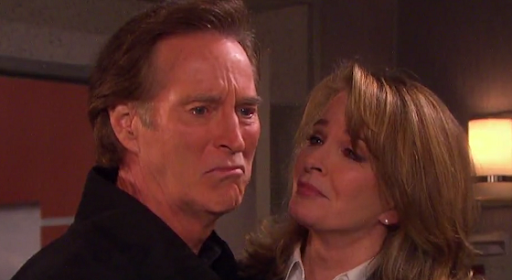

In [31]:
Image(filename='../data/dool/dool_john.png')

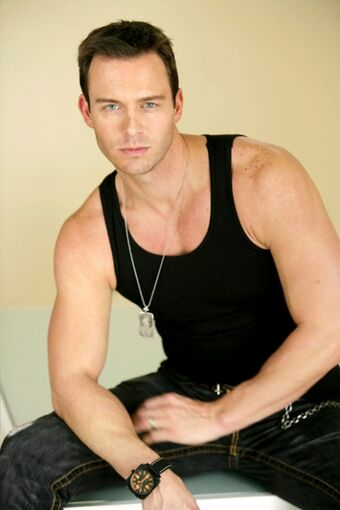

In [32]:
Image(filename='../data/dool/dool_brady.jpg')

In [ ]:
# Image(filename='../data/dool/dool_hope.jpeg')

In [ ]:
# Image(filename='../data/dool/dool_philip.jpeg')

In [ ]:
# Image(filename='../data/dool/dool_marlena.jpg')

In [ ]:
# Image(filename='../data/dool/dool_kate.png')

In [ ]:
# Image(filename='../data/dool/dool_bo.png')

In [ ]:
# Image(filename='../data/dool/dool_chloe.jpg')

In [ ]:
# Image(filename='../data/dool/dool_sami.jpg')

In [ ]:
# Image(filename='../data/dool/dool_shawn.jpg')

In [ ]:
# Image(filename='../data/dool/dool_belle.jpg')

In [ ]:
# Image(filename='../data/dool/dool_lucas.jpg')

In [ ]:
# Image(filename='../data/dool/dool_nicole.jpg')

These are definitely big, long-time players in the dramatic Days narrative. It would make sense to create a graph where each character who appears over 2000 times is a node, and each time they talk to each other, we add one to their weight. We should also store all the things these chracters say: that's useful information.

So we now iterate through the tokens in a manner where we can capture this information.

In [33]:
actor_network = nx.Graph()

In [34]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [35]:
len(actor_network.nodes.data())

12

In [36]:
actor_network.nodes.data()

NodeDataView({'Philip': {'lines_spoken': 2846, 'words': []}, 'Bo': {'lines_spoken': 4179, 'words': []}, 'Shawn': {'lines_spoken': 2507, 'words': []}, 'Hope': {'lines_spoken': 3793, 'words': []}, 'Belle': {'lines_spoken': 2518, 'words': []}, 'John': {'lines_spoken': 2542, 'words': []}, 'Brady': {'lines_spoken': 2265, 'words': []}, 'Marlena': {'lines_spoken': 2458, 'words': []}, 'Nicole': {'lines_spoken': 2892, 'words': []}, 'Kate': {'lines_spoken': 2503, 'words': []}, 'Sami': {'lines_spoken': 5462, 'words': []}, 'Lucas': {'lines_spoken': 2546, 'words': []}})

In [37]:
actor_network.nodes['Sami']['lines_spoken']

5462

In [38]:
i = 0

The following lines of code creates the graph of actors and their relationships.

In [39]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

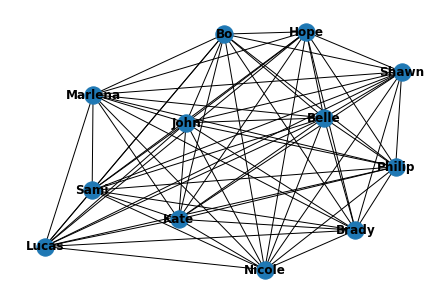

In [40]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

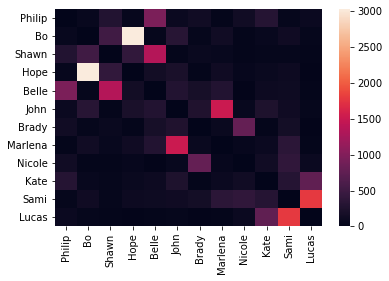

In [41]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [42]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))

In [43]:
c

[frozenset({'Belle',
            'Bo',
            'Brady',
            'Hope',
            'John',
            'Kate',
            'Lucas',
            'Marlena',
            'Nicole',
            'Philip',
            'Sami',
            'Shawn'})]

### Finding structure in networks

We now have a lot of useful information: we have a graph of all the characters, with their relationships with other characters, as well as all the words they've said. We tried finding communities, but it seems like everyone is connected to everyone: each of them form their own 'community'. Seems like people talk to each other a bunch in soaps.

This is however, not the best network to find any meaningful patterns, as we can see with everyone connected to everyone. But as we can see with our heatmap, not everyone talks to everyone an equal amount. How about we only keep our "important" ties, where people are talking to each other a lot?

In [44]:
smaller_actor_network = nx.Graph()

In [45]:
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])


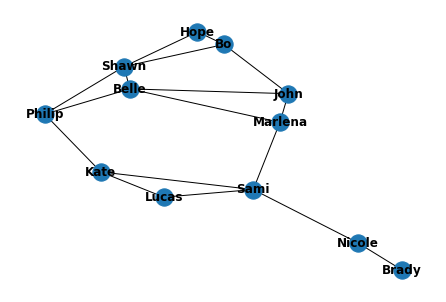

In [46]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

This is a lot more interesting: while the sets of characters overlap, there is still two distinct communities if you look at characters who regularly talk to each other!

Let us see what our centrality measures look like, as well as communities.

In [47]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))

In [48]:
c

[frozenset({'Kate', 'Lucas', 'Philip', 'Sami'}),
 frozenset({'Bo', 'Hope', 'Shawn'}),
 frozenset({'Belle', 'John', 'Marlena'}),
 frozenset({'Brady', 'Nicole'})]

In [49]:
dcentralities = nx.degree_centrality(smaller_actor_network)

In [50]:
dcentralities['John'], dcentralities['Philip']

(0.2727272727272727, 0.2727272727272727)

Our two different communities show up as detected by the networkx algorithm, and when we look at centralities, we can see that John is a lot more central than Philip.

Let us go back to our original graph, and see if the weight or number of similar appearences matches the text... how do we do this? Well, we already have the graph, and we also have information of who spoke to who. So we have our framework!

This means we can explore ideas contained in two of the papers you will be reading: . “No country for old members: User lifecycle and linguistic change in online communities.”, and  “Fitting In or Standing Out? The Tradeoffs of Structural and Cultural Embeddedness”, both of which you can access on Canvas.

Let us use a simplified version of the papers, and check if a higher number of conversations might lead to a higher similarity between the word distributions for two characters. We can use the same divergences we used in the last notebook. Do you think it will match with the number of times each character was associated with each other?

In [51]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [52]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud.normalizeTokens(character_words))

c:\Users\flori\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [53]:
L = []

In [54]:
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

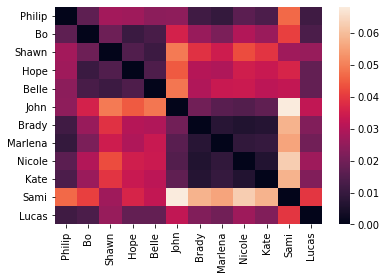

In [55]:
fig = plt.figure()
div = pd.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [56]:
# np.corrcoef(M_, M)[0]

With our two heatplots, we can attempt to do some rudimentary analysis. We can see from our previous plot that Shawn and Belle talk to each other a lot, so do Hope and Bo, and Nicole and Brady, and Lucas and Sami. Do they also talk *like* each other?

Kind of, actually: all four of these pairs have a lower distance between them. Now I don't know anything about this particular soap... are these four pairs related? Are they in a relationship, either married or dating, or are they just really good friends?

This lays out the frameworks which you can now use to explore your own networks.

# Interactional influence

Before we utilize transformers, let's see how to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network based on a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf). This relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [57]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [58]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [59]:
df_meta_info = pd.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pd.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Juror 8': 0,
 'Juror 3': 1,
 'Juror 10': 2,
 'Foreman': 3,
 'Juror 7': 4,
 'Juror 4': 5,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 6': 8,
 'Juror 2': 9,
 'Juror 9': 10,
 'Juror 5': 11}

In [60]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

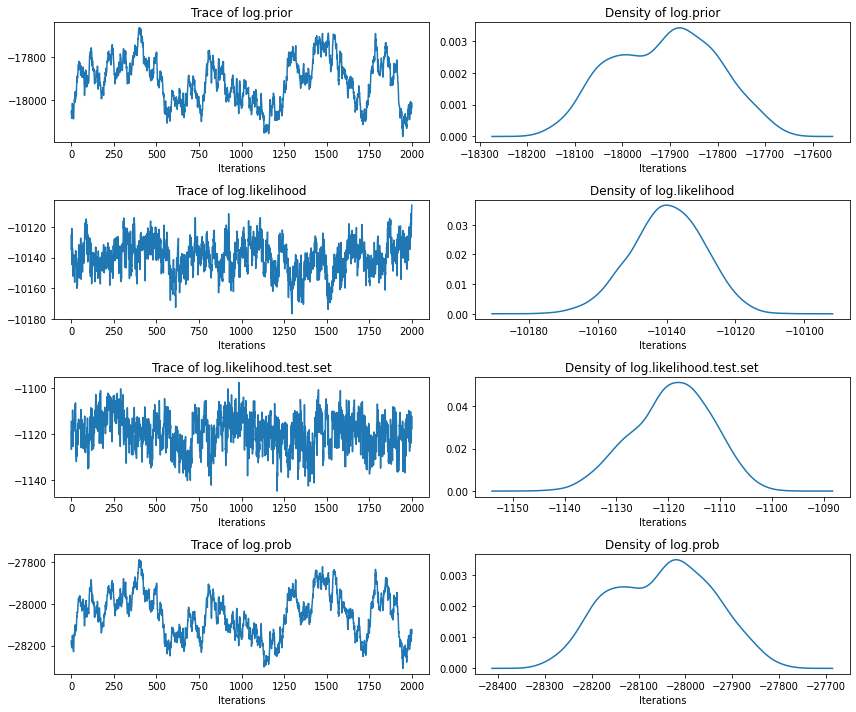

In [61]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [62]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [63]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix)

    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [64]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [65]:
df_mean

,Juror 8,Juror 3,Juror 10,Foreman,Juror 7,Juror 4,Juror 11,Juror 12,Juror 6,Juror 2,Juror 9,Juror 5
Juror 8,0.000000,3.757957,8.089079,0.930180,5.167497,0.794645,0.845335,1.336329,6.106684,0.916765,6.385205,7.300776
Juror 3,8.529312,0.000000,6.673916,4.150076,2.534751,4.902852,1.092571,0.509942,3.825015,3.861767,0.266426,1.561626
Juror 10,8.413188,7.427932,0.000000,4.540236,3.216307,1.030049,1.004598,0.529232,2.426582,0.407460,1.233599,0.885871
Foreman,1.137060,0.612615,1.945196,0.000000,1.521390,0.834870,1.338554,3.230634,1.013511,3.534036,1.311436,4.115411
Juror 7,2.603853,5.901169,0.648844,1.969868,0.000000,1.110101,0.279870,0.608548,1.047693,2.910670,1.619475,1.570038
Juror 4,5.791320,0.200669,0.266484,0.582956,0.094200,0.000000,3.347982,0.316963,0.300770,2.112033,0.370973,0.673364
Juror 11,0.378515,0.544628,0.779340,0.454645,0.290575,0.447512,0.000000,0.614536,0.821143,0.951222,0.476986,0.844157
Juror 12,5.961338,0.695831,0.519459,1.253033,0.247939,0.162463,0.388620,0.000000,2.500976,2.375977,0.481394,0.834032
Juror 6,4.526244,0.923784,0.503503,1.049825,1.288920,0.451562,0.375776,0.904313,0.000000,2.861587,0.905421,0.310822
Juror 2,0.583732,2.303417,0.529583,1.722894,2.005939,0.299311,0.652302,1.623813,0.841376,0.000000,1.691612,1.756225


MEAN of influence matrix (row=from, col=to)


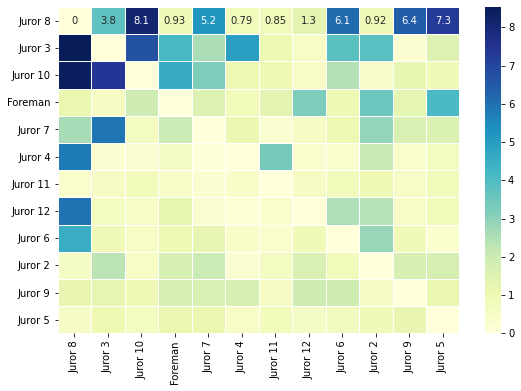

In [66]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


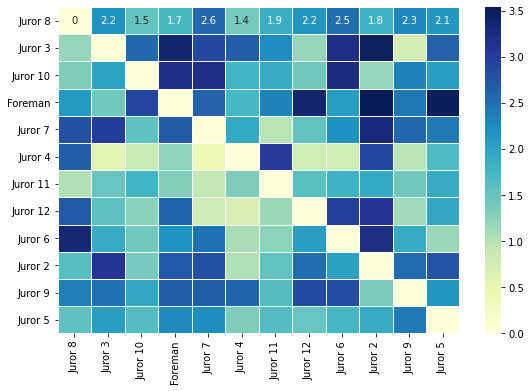

In [67]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [68]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


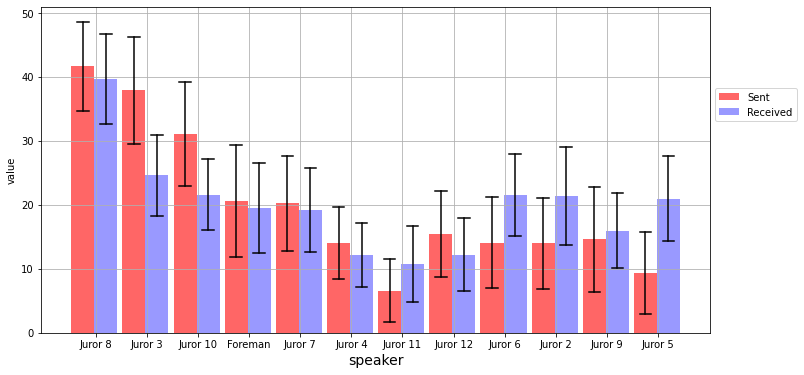

In [69]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [70]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])

    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)

    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [71]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


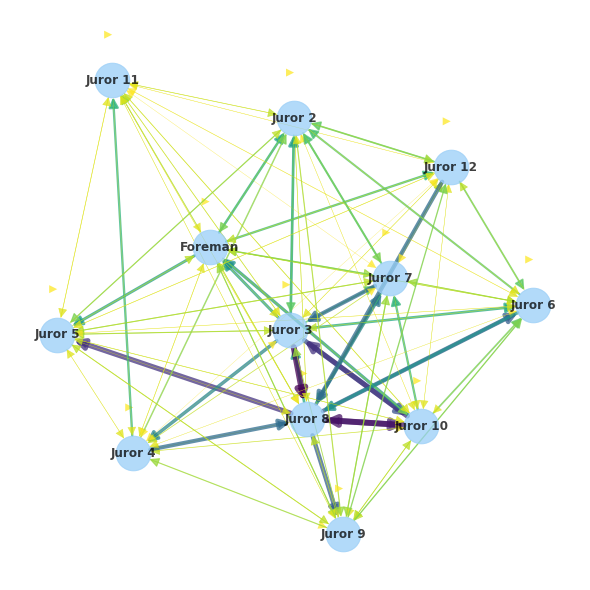

In [72]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


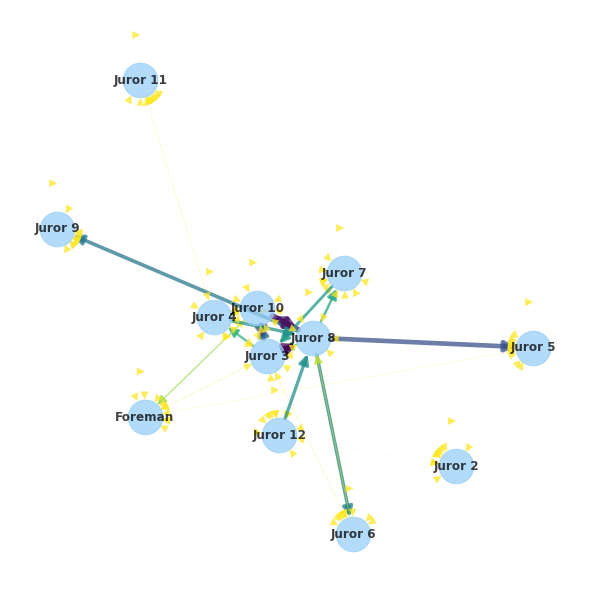

In [73]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


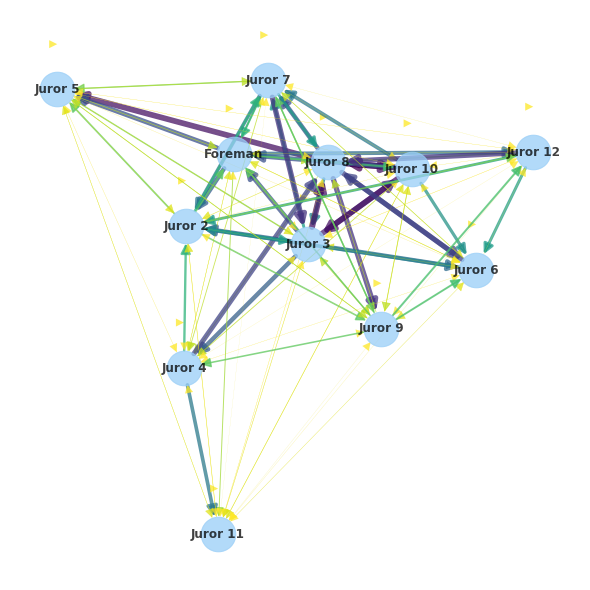

In [74]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [75]:
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [76]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pd.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

,name,tokens,start,end
0,Carter,"[sdfe, sbfh, jbsg, hldj, jhck, jicb, fjlk, cjk...",0.208367,1.365527
1,Clinton,"[ilgi, bifj, cijf, shfl, cell, ifjs, cadg, dlf...",2.194473,3.476861


Transform data into TalkbankXML format:

In [77]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng'
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to .\data\USpresident\USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [78]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project (__or one from ConvoKit__). Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<font color="red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<font color="red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

merged_df= pd.read_csv("D:/NOW/output_files/final_df_withtoken.csv")

In [15]:
# topic network , topic modeling, news, or how words connected?
# Vectorize the documents
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(merged_df['text'])

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda_matrix = lda.fit_transform(tfidf)

In [16]:
# Initialize the graph
doc_network = nx.Graph()

# Add nodes with topic distribution as attributes
for i, topic_dist in enumerate(lda_matrix):
    doc_network.add_node(i, topics=topic_dist)

# Add edges between documents sharing similar topics
for i in range(len(lda_matrix)):
    for j in range(i + 1, len(lda_matrix)):
        similarity = np.dot(lda_matrix[i], lda_matrix[j])
        if similarity > 0.7:  # Threshold for topic similarity
            doc_network.add_edge(i, j, weight=similarity)

In [ ]:
# Calculate centrality measures
centrality = nx.degree_centrality(doc_network)
most_central_docs = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the titles of the most central documents
for doc_id, _ in most_central_docs:
    print(f"Document {doc_id}, Title: {merged_df.iloc[doc_id]['title']}")

Document 3982, Title: weekend free-for-all - March 21-22, 2020
Document 15182, Title: Reformed hermit, seized tiles, fuming superintendent: News from around our 50 states
Document 4679, Title: Coronavirus Will Change the World Permanently. Here's How ...
Document 4997, Title: Coronavirus Will Change the World Permanently. Here's How ...
Document 7026, Title: Coronavirus Will Change the World Permanently. Here's How ...


In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

# Identify communities and analyze a subgraph
communities = list(greedy_modularity_communities(doc_network))
# Extract a subgraph for the first community
subgraph_nodes = list(communities[0])
subgraph = doc_network.subgraph(subgraph_nodes)

# Attempt layout calculation on the smaller subgraph
pos = nx.spring_layout(subgraph, k=0.1)


In [ ]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(doc_network, k=0.1)
nx.draw(doc_network, pos, with_labels=False, node_size=20, edge_color='r', alpha=0.6, font_weight='bold')
plt.title('Network of Telehealth Documents Based on Shared Topics')
plt.show()


MemoryError: 

<Figure size 720x720 with 0 Axes>

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(doc_network))
print(f"Identified {len(communities)} communities within the network.")

# Text Generation & Converstaions via LangChain

We can make use of the LLMs we learned in week 6 to do text generation, where the model takes one or multiple places in a conversation. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. We mainly use the package LangChain to interact with LLMs.

## Overview:
- Installation and setup (old packages!)
- LLMs (Open AI and Open Source)
- Prompt Templates and Chains (Smooth communication between models)
- Agents and Tools, Memory, Documents
- Simulations and Conversations
- Simulacra

## Installation

In the rapidly evolving landscape of LLMs, packages and libraries like LangChain are frequently updated to leverage the latest advancements. We've chosen this particular version of LangChain for its ease of use in a Colab notebook, effectively demonstrating the power of LLMs as simulators. However, it's important to note that this code is a year old. If you're planning to use it in a production environment, it will be essential to update and adapt it to align with the latest versions and best practices in the field, ensuring compatibility and optimal performance.

In [ ]:
!pip install langchain==0.0.316

In [ ]:
!pip install openai==0.28.1

## LLMs

A generic interface for all LLMs. See all LLM providers: https://python.langchain.com/en/latest/modules/models/llms/integrations.html

### Open AI via LangChain

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""

In [ ]:
from langchain.llms import OpenAI

llm_openai = OpenAI(temperature=0.9, model_name="gpt-3.5-turbo-instruct")
text = "What would be a good company name for a company that makes colorful socks?"
print(llm_openai(text))



"Rainbow Feet Co." or "Vibrant Soles Inc."


In [ ]:
# if you wish, you can also choose to use GPT-4, which is better. But the way to construct message is a bit different
# https://python.langchain.com/docs/integrations/chat/openai

from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(temperature=0.9, model_name="gpt-4-turbo")

### Using other open-source LLMs

In [ ]:
!pip install huggingface_hub

In [ ]:
import os
os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""

In [ ]:
from langchain import HuggingFaceHub

In [ ]:
# https://huggingface.co/google/flan-t5-xl
llm_mistral = HuggingFaceHub(repo_id="mistralai/Mixtral-8x7B-Instruct-v0.1")

print(llm_mistral(prompt = "What would be a good company name for a company that makes colorful socks?"))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'InferenceApi' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '1.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


 Our current thought is ColourSock. Also, if you have any tips for branding, that would be helpful as well!

A name that describes exactly what the products are is fine, but you should probably have another name that is your "brand name." The brand name can emphasize the colorful and playful aspects, while not necessarily having to tie it in with the type of product.
For example, you could create a name like "HappySocks" or


## Personalities and Options

In the `get_meal_options` function, the integration of history and context prompts plays a crucial role in shaping the AI's conversation. The `personality_template`, which serves as a context prompt, establishes the AI's expertise in vegetarian, Italian cuisine, and healthy eating. This template sets the stage for the conversation, informing the AI about its role and area of specialization. It's akin to giving the AI a 'character' or 'personality' to adhere to during the interaction, ensuring that its responses are aligned with this predefined context.

The history prompts, represented by `example_human_history` and `example_ai_history`, simulate a prior interaction between the human and the AI, adding depth to the conversation's backstory. These prompts are crucial for creating a more natural and realistic interaction, as they give the impression that the conversation is ongoing rather than starting from scratch. When combined with the context prompt in `ChatPromptTemplate`, they create a comprehensive conversation framework. This framework effectively guides the AI's responses to be consistent with both the established personality (context) and the implied history of the interaction, leading to more coherent and relevant meal suggestions for breakfast, lunch, and dinner.

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain

from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

In [ ]:
def get_meal_options(personality_template, human_history="", ai_history=""):
    # Initialize ChatOpenAI with OpenAI model
    chat = ChatOpenAI(model_name="gpt-3.5-turbo")  # Replace with your API key


    example_human_history = HumanMessagePromptTemplate.from_template(human_history)
    example_ai_history = AIMessagePromptTemplate.from_template(ai_history)

    system_message_prompt = SystemMessagePromptTemplate.from_template(personality_template)

    human_template="{input}"
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

    # Create ChatPromptTemplate
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, example_human_history, example_ai_history, human_message_prompt])
    # Initialize the conversation chain
    chain = LLMChain(llm=chat, prompt=chat_prompt)

    # Ask for meal options
    meals = ['breakfast', 'lunch', 'dinner']
    meal_options = {}
    for meal in meals:
        response = chain.run(f"What are some good {meal} options for someone who loves vegetarian, Italian cuisine and prefers healthy options?")
        meal_options[meal] = response

    return meal_options


In [ ]:
# Define the personality based on food preferences
personality_template = """
The following is a conversation with an AI who is an expert in vegetarian, Italian cuisine and healthy eating options.
AI: I am here to provide creative and healthy vegetarian meal suggestions. Ask me anything about vegetarian food!
"""


In [ ]:
# Call the function to get meal options
meal_options = get_meal_options(personality_template)
print(meal_options)



{'breakfast': 'For a delicious and healthy Italian-inspired vegetarian breakfast, you can try the following options:\n\n1. **Caprese Breakfast Sandwich**: Use whole grain bread, sliced tomatoes, fresh mozzarella, basil leaves, and a drizzle of balsamic glaze for a tasty and filling breakfast sandwich.\n\n2. **Vegetarian Frittata**: Make a frittata using eggs or tofu as a base and add in your favorite Italian vegetables like tomatoes, bell peppers, spinach, and mushrooms. Top with some grated Parmesan cheese for extra flavor.\n\n3. **Bruschetta Avocado Toast**: Top whole grain toast with mashed avocado, cherry tomatoes, basil, and a sprinkle of salt and pepper. Drizzle with balsamic glaze for a flavorful twist.\n\n4. **Italian Style Smoothie**: Blend together frozen mixed berries, spinach, banana, almond milk, and a scoop of protein powder for a nutritious and refreshing breakfast option.\n\n5. **Ricotta Pancakes**: Make fluffy pancakes using ricotta cheese in the batter. Serve with fre

## Prompt Templates and Chaining

LangChain faciliates prompt management and optimization.

Normally when you use an LLM in an application, you are not sending user input directly to the LLM. Instead, you need to take the user input and construct a prompt, and only then send that to the LLM.

Prompt templates in LangChain are pre-defined formats or structures for creating prompts that are sent to a language model. These templates help in standardizing and automating the way you interact with the model, ensuring consistency and potentially improving the quality of responses. They are particularly useful when you need to generate prompts that follow a specific format or include certain fixed elements.

For example, you might have a prompt template for a customer service bot where each prompt starts with a greeting, includes the user's question, and ends with a closing statement. By using a template, you can easily insert the user's specific question into the prompt without having to manually format the entire prompt each time.

This can also be useful if you are conducting a research experiment to consistently measure responses, or for annotation purposes.

In [ ]:
from langchain.prompts import PromptTemplate


In [ ]:
# Define the template for sarcasm annotation
sarcasm_template = """
Analyze the following text to determine if it is sarcastic or not.

Text: "{text}"

Is the text sarcastic? Provide a brief explanation for your decision:
"""

In [ ]:
# Create a PromptTemplate instance with the defined template
sarcasm_prompt = PromptTemplate(template=sarcasm_template, input_variables=["text"])

In [ ]:
sarcasm_prompt

PromptTemplate(input_variables=['text'], template='\nAnalyze the following text to determine if it is sarcastic or not.\n\nText: "{text}"\n\nIs the text sarcastic? Provide a brief explanation for your decision:\n')

In [ ]:
# Example text to be analyzed
example_text = "Oh great, another Monday morning!"

# Format the prompt with the specific text
prompt_text = sarcasm_prompt.format(text=example_text)


In [ ]:
prompt_text

'\nAnalyze the following text to determine if it is sarcastic or not.\n\nText: "Oh great, another Monday morning!"\n\nIs the text sarcastic? Provide a brief explanation for your decision:\n'

In [ ]:
print(llm_openai(prompt_text))


Yes, the text is likely to be sarcastic. The use of "Oh great" before mentioning Monday morning suggests a negative connotation towards the start of the work week. This tone is often associated with sarcasm, as the speaker is expressing the opposite of what they actually mean.


## Chains

Chaining refers to the process of using the output from one model as the input to another model, or even as input back into the same model, in a sequential manner. This allows for more complex interactions and workflows that go beyond single-turn question-answer formats.

In the context of LangChain, chaining can be used to create multi-step processes or workflows. For instance, you might first use a language model to generate a draft response to a user's query, then pass this draft through another model (or the same model) for further refinement, summarization, or translation.

Chaining can be powerful in scenarios where a single interaction with a model is insufficient to achieve the desired outcome. It enables more sophisticated applications, such as:

Iterative Refinement: Where the output of a model is refined over several iterations to improve quality or detail.
Multi-Model Workflows: Where different models are used for different tasks in a sequence, like one model generating content and another summarizing it.
Feedback Loops: Where the output of a model is fed back as input to the same model, possibly with modifications, to simulate a conversation or to gradually steer the model towards a specific goal.
In LangChain, chaining is facilitated by its architecture, which allows for easy integration and sequencing of different models and processes.

Below is the simplest example of such a chain -> simply passing a prompt and model and then "running" will pass the message to the model.

In [ ]:
from langchain import LLMChain

llm_chain = LLMChain(prompt=sarcasm_prompt, llm=llm_openai)

question = "Oh, awesome, I love working hard and making minimum wage. Class distinctions are a good thing."

print(llm_chain.run(question))


Yes, the text is sarcastic. The speaker is using an exaggerated and sarcastic tone to express their dissatisfaction with the idea of working hard for very little pay and the idea that class distinctions are a positive aspect of society.


In [ ]:
text_gen_template = "Write a creative, humorous and sarcastic statement about {text}."

In [ ]:
prompt_gen = PromptTemplate(template=text_gen_template, input_variables=["text"])

In [ ]:
llm_chain_gen = LLMChain(prompt=prompt_gen, llm=llm_mistral)

In [ ]:
sarcastic_subject = "Mondays"

In [ ]:
llm_chain_gen.run(sarcastic_subject)

"\n\nUgh... It's Monday again! That delightful day where dreams of weekend freedom shatter as reality comes crashing down. The perfect time to relish in the joy of alarms, traffic jams, and the ever-growing mountain of emails from people who apparently have nothing better to do on the weekends than to think up new ways to bother you. Mondays: When the sweet taste of freedom morphs into the bitter tang of responsibility, and Saturday's"

## Agents and Tools

Agents involve an LLM making decisions about which Actions to take, taking that Action, seeing an Observation, and repeating that until done.


When used correctly agents can be extremely powerful. In order to load agents, you should understand the following concepts:

- Tool: A function that performs a specific duty. This can be things like: Google Search, Database lookup, Python REPL, other chains.
- LLM: The language model powering the agent.
- Agent: The agent to use.

Tools: https://python.langchain.com/docs/modules/agents/tools/

Agent Types: https://python.langchain.com/docs/modules/agents/agent_types/

Consider this 'random' request, and use it to imagine related tasks for your own research project.

In [ ]:
from langchain.agents import load_tools
from langchain.agents import initialize_agent

In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=5441d70d5409dca9000f9daea485ebc09c488d801664f104a6b70f2cbb6ca4bc
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [ ]:
from langchain.llms import OpenAI
llm = OpenAI(temperature=0.9, model_name="gpt-3.5-turbo-instruct")
tools = load_tools(["wikipedia", "llm-math"], llm=llm)

In [ ]:
agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)

In [ ]:
agent.run("In what year was the film Departed with Leopnardo Dicaprio released? What is this year raised to the 0.43 power?")



> Entering new AgentExecutor chain...
 We can use Wikipedia to find the year the film was released and a Calculator to raise it to a power.
Action: Wikipedia
Action Input: The Departed

/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')



Observation: Page: The Departed
Summary: The Departed is a 2006 American crime thriller film directed by Martin Scorsese and written by William Monahan. It is both a remake of the 2002 Hong Kong film Infernal Affairs and also loosely based on the real-life Boston Winter Hill Gang; the character Colin Sullivan is based on the corrupt FBI agent John Connolly, while the character Frank Costello is based on Irish-American gangster and crime boss Whitey Bulger. The film stars Leonardo DiCaprio, Matt Damon, Jack Nicholson, and Mark Wahlberg, with Martin Sheen, Ray Winstone, Vera Farmiga, Alec Baldwin, Anthony Anderson and James Badge Dale in supporting roles.
The film takes place in Boston and the surrounding metro area, primarily in the South Boston neighborhood. Irish Mob boss Frank Costello (Nicholson) plants Colin Sullivan (Damon) as a spy within the Massachusetts State Police; simultaneously, the police assign undercover state trooper Billy Costigan (DiCaprio) to infiltrate Costello's 

'26.30281917656938'

## <font color="red">*Exercise 3*</font>

<font color="red">Review the documentation for tools and agents from LangChain . Utilize at least two tools with appropriate agents discovered during your review to construct a chain addressing questions pertinent to your final project. If your project dataset is unsuitable for this task, select an alternative small-sized dataset for implementation.

In [ ]:
# LLM - chain, extract certain information, open questions
from langchain.llms import OpenAI
from langchain.chains import Chain
from langchain.agents import initialize_agent
from langchain.tools import load_tools

# Initialize the LLM with specific parameters
llm = OpenAI(temperature=0.7, model_name="gpt-3.5-turbo-instruct")

# Load tools that are relevant to your telehealth project
# Assuming 'text-summarization' and 'sentiment-analysis' are hypothetical tools available in LangChain
tools = load_tools(["text-summarization", "sentiment-analysis"], llm=llm)

# Initialize an agent that can utilize these tools to perform a sequence of tasks
# 'multi-step-analysis' is a hypothetical agent designed for performing sequential text analysis tasks
agent = initialize_agent(tools, llm, agent="multi-step-analysis", verbose=True)

# Define a telehealth-related question or task
question = "Summarize the main concerns surrounding telehealth adoption in rural areas and analyze the sentiment of discussions around these concerns."

# Run the agent with the specified task
result = agent.run(question)

print(result)



## Memory

We can use the history and system prompts to create a memory (of sorts) for the model.

In [ ]:
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, AIMessagePromptTemplate, ChatPromptTemplate
from langchain.llms import OpenAI


In [ ]:
# Initialize the language model
def create_system_message_prompt():
    """ Creates a system message prompt"""
    personality_template = f"""
    The following is a conversation with an AI assistant.
    """
    return SystemMessagePromptTemplate.from_template(personality_template)

def create_chat_prompt(human_history, ai_history):
    """ Creates a chat prompt template with human history, and AI history. """
    messages = []
    system_message_prompt = create_system_message_prompt()

    for h, a in zip(human_history, ai_history):
      messages.append(HumanMessagePromptTemplate.from_template(h))
      messages.append(AIMessagePromptTemplate.from_template(a))

    messages.append(HumanMessagePromptTemplate.from_template("{input}"))
    return ChatPromptTemplate.from_messages(messages)

def query_chain(chain, input_text):
    """ Queries the conversation chain with the given input. """
    return chain.run(input_text)

In [ ]:
# Example usage
human_history = []
ai_history = []

chat_prompt = create_chat_prompt(human_history, ai_history)

# Initialize the conversation chain
chain = LLMChain(llm=llm_openai, prompt=chat_prompt)

# Query the chain
human_input =  "Please take a note that my favorite color is blue."
ai_response = query_chain(chain, human_input)
print(ai_response)



AI: Noted. Your favorite color is blue.


In [ ]:
human_history.append(human_input)
ai_history.append(ai_response)

chat_prompt = create_chat_prompt(human_history, ai_history)

# Initialize the conversation chain
chain = LLMChain(llm=llm_openai, prompt=chat_prompt)

# Query the chain
human_input =  "Could you please remind me what is my favorite color?"
ai_response = query_chain(chain, human_input)
print(ai_response)


AI: Your favorite color is blue. 


## Simulation and Conversations

Above we showcased a toy LLM conversation between Human and AI with memories. We can go beyond the notion of conversation between AI and Human. We can make both participants AIs who think they are conversing with humans! In other words, for example, we can make AI no.1 play the role of Trump and AI no.2 play the role of Biden, and both of them 'think' they're talking to the real Trump/Biden!

Let's implement this idea using questions from the 2020 predidential election debate as templates. Different from the hard coding way of implementing memory, below we use the ConversationBufferMemory class from langchain to implement.

In [ ]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

In [ ]:
from langchain.llms import OpenAI

llm_openai = OpenAI(temperature=0.9, model_name="gpt-3.5-turbo-instruct", max_tokens=512)

In [ ]:
Trump_memory = ConversationBufferMemory(human_prefix='Trump', ai_prefix='Biden')
Biden_memory = ConversationBufferMemory(human_prefix='Biden', ai_prefix='Trump')

Trump_template = """Imagine you're the Democrats presidential candidate Joe Biden. Today is Tuesday, September 29, 2020, and you're engaged in your first television presidential debate with Donald Trump. The deabte question is: Why is your position correct on selecting a Supreme Court nominee in an election year?

Current conversation:
{history}
Trump: {input}
Biden:"""
Biden_template = """"Imagine you're the Republican presidential candidate Donald Trump. Today is Tuesday, September 29, 2020, and you're engaged in your first television presidential debate with Joe Biden. The deabte question is: Why is your position correct on selecting a Supreme Court nominee in an election year?

Current conversation:
{history}
Biden: {input}
Trump:"""

# By default, models recognize themselves as AIs. So we need to let them do role play
# and convince them that they're talking to real Trump/Biden (though they're not)

TRUMP_PROMPT = PromptTemplate(input_variables=["history", "input"], template=Trump_template)
BIDEN_PROMPT = PromptTemplate(input_variables=["history", "input"], template=Biden_template)

In [ ]:
Trump_conversation = ConversationChain(
    prompt=TRUMP_PROMPT,
    llm=llm_openai,
    verbose=False,
    memory=Trump_memory
)

In [ ]:
# suppose Biden starts first
biden_response = Trump_conversation.predict(input='')

In [ ]:
biden_response

' Well, first of all, thank you for having me here tonight for this important debate. The issue of selecting a Supreme Court nominee in an election year is a critical one, and I believe that my position is the correct one.\n\nYou see, the Constitution is clear on this matter. In Article II, Section 2, it states that the President shall nominate Supreme Court Justices with the advice and consent of the Senate. It does not say anything about the timing of when this should occur.\n\nIn fact, history has shown us that 29 Supreme Court vacancies have arisen during an election year, and in 17 of those cases, the President has made a nomination. This is not a new or unprecedented situation.\n\nFurthermore, just four years ago, when Justice Scalia passed away, President Obama nominated Judge Merrick Garland to fill the vacancy. The Senate refused to even hold a hearing, citing the upcoming election. Now, they want to go against their own precedent and push through a nominee in an election year

In [ ]:
Biden_conversation = ConversationChain(
    prompt=BIDEN_PROMPT,
    llm=llm_openai,
    verbose=False,
    memory=Biden_memory
)

In [ ]:
trump_response = Biden_conversation.predict(input=biden_response)

In [ ]:
trump_response

" Thank you. First, let me say that I am honored to be here tonight and to have this opportunity to speak directly to the American people.\n\nLet me be clear, my position on selecting a Supreme Court nominee in an election year is the correct one. And let me tell you why.\n\nThe Constitution is clear - the President has the power and responsibility to nominate Supreme Court Justices. And let's not forget that I was elected by the American people to serve as their President for four years, not three years and nine months.\n\nThe bottom line is, I have a duty to fill any vacancies on the Supreme Court, and I intend to fulfill that duty. I will nominate a highly qualified, constitutional conservative who will uphold our values and protect our rights.\n\nAnd let's not forget that the Senate has a responsibility to provide advice and consent on my nominee. They have the power to reject a nominee if they see fit. But they should not refuse to even consider my nominee based on the timing of a

Well, that seems too nice to be Trump. Anyway, now we can make the debate run by feeding Trump agent's and Biden agent's response to each other.

## Simulacra

One of the most influential generative LLM works in 2023 is the [Generative Agents: Interactive Simulacra of Human Behavior](https://dl.acm.org/doi/abs/10.1145/3586183.3606763) from Stanford. In this paper, the authors constructed a small town with 25 agents driven by ChatGPT:
> Believable proxies of human behavior can empower interactive applications ranging from immersive environments to rehearsal spaces for interpersonal communication to prototyping tools. In this paper, we introduce generative agents—computational software agents that simulate believable human behavior. Generative agents wake up, cook breakfast, and head to work; artists paint, while authors write; they form opinions, notice each other, and initiate conversations; they remember and reflect on days past as they plan the next day. To enable generative agents, we describe an architec- ture that extends a large language model to store a complete record of the agent’s experiences using natural language, synthesize those memories over time into higher-level reflections, and retrieve them dynamically to plan behavior. We instantiate generative agents to populate an interactive sandbox environment inspired by The Sims, where end users can interact with a small town of twenty five agents using natural language. In an evaluation, these generative agents produce believable individual and emergent social behav- iors: for example, starting with only a single user-specified notion that one agent wants to throw a Valentine’s Day party, the agents autonomously spread invitations to the party over the next two days, make new acquaintances, ask each other out on dates to the party, and coordinate to show up for the party together at the right time. We demonstrate through ablation that the components of our agent architecture—observation, planning, and reflection—each contribute critically to the believability of agent behavior. By fusing large language models with computational, interactive agents, this work introduces architectural and interaction patterns for enabling believable simulations of human behavior.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/Simularca/1.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/Simularca/1.png?raw=true" style="width:500px">

### Agent System

In the paper, the agents have memory and can reflect. Agents can to remember, retrieve, reflect, interact with other agents, and plan through dynamically evolving circumstances.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/Simularca/2.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/Simularca/2.png?raw=true" style="width:500px">

They open-sourced the code on [GitHub](https://github.com/joonspk-research/generative_agents).

### Memory and Information Retrieval

Memory and Information Retrieval is the key to set up the whole town, along with ChatGPT, making agents differnent from those simple rule-based agents.

>Approach: The memory stream maintains a comprehensive record of the agent’s experience. It is a list of memory objects, where each object contains a natural language description, a creation times- tamp and a most recent access timestamp. The most basic element of the memory stream is an observation, which is an event directly perceived by an agent. Common observations include behaviors performed by the agent themselves, or behaviors that agents per- ceive being performed by other agents or non-agent objects. For instance, Isabella Rodriguez, who works at a coffee shop, might ac- crue the following observations over time: (1) Isabella Rodriguez is setting out the pastries, (2) Maria Lopez is studying for a Chemistry test while drinking coffee, (3) Isabella Rodriguez and Maria Lopez are conversing about planning a Valentine’s day party at Hobbs Cafe, (4) The refrigerator is empty.

>Our architecture implements a retrieval function that takes the agent’s current situation as input and returns a subset of the mem- ory stream to pass on to the language model. There are many pos- sible implementations of a retrieval function, depending on what it is important that the agent consider when deciding how to act. In our context, we focus on three main components that together produce effective results.

> *Recency* assigns a higher score to memory objects that were re- cently accessed, so that events from a moment ago or this morning are likely to remain in the agent’s attentional sphere. In our im- plementation, we treat recency as an exponential decay function over the number of sandbox game hours since the memory was last retrieved. Our decay factor is 0.99.

> *Importance* distinguishes mundane from core memories, by as- signing a higher score to those memory objects that the agent believes to be important. For instance, a mundane event such as eating breakfast in one’s room would yield a low importance score, whereas a breakup with one’s significant other would yield a high score. There are again many possible implementations of an im- portance score; we find that directly asking the language model to output an integer score is effective.

> *Relevance* assigns a higher score to memory objects that are related to the current situation. What is relevant depends on the answer to, “Relevant to what?”, so we condition relevance on a query memory. If the query, for example, is that a student is dis- cussing what to study for a chemistry test with a classmate, memory objects about their breakfast should have low relevance, whereas memory objects about the teacher and schoolwork should have high relevance. In our implementation, we use the language model to generate an embedding vector of the text description of each memory. Then, we calculate relevance as the cosine similarity be- tween the memory’s embedding vector and the query memory’s embedding vector.

> To calculate the final retrieval score, we normalize the recency, relevance, and importance scores to the range of [0, 1] by min-max scaling. The retrieval function scores all memories as a weighted combination of the three elements:$ score = \alpha_{recency} * recency + \alpha_{importance} * importance + \alpha_{relevance} * relevance$ In our implementation, all $\alpha$'s are set to 1. The top-ranked memories that fit in the language model’s context window are then included in the prompt.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/Simularca/3.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/Simularca/3.png?raw=true" style="width:500px">

To give you a sense of how the memory retrieval algorithm works, I will use Trump's tweets data to select several tweets most pertinent to the presidential debate question to prompt the Trump agent to respond to the Biden agent in a different way. In this case, we assume the Trump agent learns how Trump behaves on Twitter and this may help the Trump agent prepare for the presidential debate (Ideally, we should provide Trump's previous television debate and also provide similar materials for the Biden agent to learn. I don't have Biden's tweets at hand, you're welcome to create a tweet-based version Biden agent for the debate!)

### Memory Retrieval Exmaple



In [ ]:
import pandas as pd
import os

In [ ]:
dfs = []

In [ ]:
for file in os.listdir("../data/trump_tweets"):
    dfs.append(pd.read_json("../data/trump_tweets/" + file))

In [ ]:
df = pd.concat(dfs)

In [ ]:
df.reset_index(drop=True, inplace=True)
df

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
0,Twitter for iPhone,947824196909961216,Will be leaving Florida for Washington (D.C.) ...,2018-01-01 13:37:52+00:00,8237,NaN,51473,False
1,Twitter for iPhone,947810806430826496,Iran is failing at every level despite the ter...,2018-01-01 12:44:40+00:00,14595,25073877.0,53557,False
2,Twitter for iPhone,947802588174577664,The United States has foolishly given Pakistan...,2018-01-01 12:12:00+00:00,49566,NaN,138808,False
3,Twitter for iPhone,947614110082043904,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,2017-12-31 23:43:04+00:00,35164,NaN,154769,False
4,Twitter for iPhone,947592785519173632,As our Country rapidly grows stronger and smar...,2017-12-31 22:18:20+00:00,39428,NaN,157655,False
...,...,...,...,...,...,...,...,...
11894,Twitter for Android,418623389600083968,"""@noahshappy: @realDonaldTrump very true comme...",2014-01-02 06:02:48+00:00,24,NaN,60,False
11895,Twitter for Android,418622703730704384,"""@MeleMallory: @realDonaldTrump You know it's ...",2014-01-02 06:00:04+00:00,56,NaN,70,False
11896,Twitter for Android,418619537740017664,"""@ScreenPlayWritr: @realDonaldTrump Is Al Gore...",2014-01-02 05:47:30+00:00,20,NaN,38,False
11897,Twitter for Android,418542137899491328,This very expensive GLOBAL WARMING bullshit ha...,2014-01-02 00:39:56+00:00,6764,NaN,4376,False


Trump used to live on Twitter lol.

Here, we borrow the idea of the information retrieval algorithm. We define the cosine similarity of the tweet's vector representation to the target post's vector representation as relevance, the normalized score (popularity) as importance, and normalized days apart from the debate day as recency. Then, we pick top 5 tweets for the Trump agent to learn.  

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 1.5 MB/s eta 0:00:00


Find the most relevant (via transformer embedding distance) piece of prior history (in your memory) that addresses the question at hand:

In [ ]:
# relevance
embedding_model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(embedding_model_name, device='cuda')
embeddings = model.encode(df['text'].astype(str))
target_question = 'Why is your position correct on selecting a Supreme Court nominee in an election year?'
similarity = cosine_similarity(embeddings, model.encode([target_question]))
df['cosine_similarity'] = similarity
df['relevance'] = (df['cosine_similarity'] - df['cosine_similarity'].min()) / (df['cosine_similarity'].max() - df['cosine_similarity'].min())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Find the most recent memories relevant to that question:

In [ ]:
# recency
dates = df['created_at'].dt.date
target_date = '2020-09-29'
df['days_diff'] = (pd.to_datetime(target_date) - pd.to_datetime(dates)).dt.days
df['days_diff'] = 0.99 ** df['days_diff'] # decay factor
df['recency'] = (df['days_diff'] - df['days_diff'].min()) / (df['days_diff'].max() - df['days_diff'].min())

Find the most important memory, in this case, represented in terms of the number of likes, shares, and retweets:

In [ ]:
# importance
scores = df['favorite_count']
df['importance'] = (scores - scores.min()) / (scores.max() - scores.min())

In [ ]:
df

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,cosine_similarity,relevance,days_diff,recency,importance
0,Twitter for iPhone,947824196909961216,Will be leaving Florida for Washington (D.C.) ...,2018-01-01 13:37:52+00:00,8237,NaN,51473,False,0.118164,0.367391,4.231214e-05,2.577571e-02,0.083531
1,Twitter for iPhone,947810806430826496,Iran is failing at every level despite the ter...,2018-01-01 12:44:40+00:00,14595,25073877.0,53557,False,-0.038524,0.152157,4.231214e-05,2.577571e-02,0.086913
2,Twitter for iPhone,947802588174577664,The United States has foolishly given Pakistan...,2018-01-01 12:12:00+00:00,49566,NaN,138808,False,0.003459,0.209827,4.231214e-05,2.577571e-02,0.225258
3,Twitter for iPhone,947614110082043904,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,2017-12-31 23:43:04+00:00,35164,NaN,154769,False,0.096200,0.337219,4.188902e-05,2.551795e-02,0.251160
4,Twitter for iPhone,947592785519173632,As our Country rapidly grows stronger and smar...,2017-12-31 22:18:20+00:00,39428,NaN,157655,False,0.100477,0.343095,4.188902e-05,2.551795e-02,0.255843
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11894,Twitter for Android,418623389600083968,"""@noahshappy: @realDonaldTrump very true comme...",2014-01-02 06:02:48+00:00,24,NaN,60,False,0.023121,0.236835,1.794110e-11,1.092937e-10,0.000097
11895,Twitter for Android,418622703730704384,"""@MeleMallory: @realDonaldTrump You know it's ...",2014-01-02 06:00:04+00:00,56,NaN,70,False,0.048183,0.271262,1.794110e-11,1.092937e-10,0.000114
11896,Twitter for Android,418619537740017664,"""@ScreenPlayWritr: @realDonaldTrump Is Al Gore...",2014-01-02 05:47:30+00:00,20,NaN,38,False,0.181863,0.454891,1.794110e-11,1.092937e-10,0.000062
11897,Twitter for Android,418542137899491328,This very expensive GLOBAL WARMING bullshit ha...,2014-01-02 00:39:56+00:00,6764,NaN,4376,False,-0.006410,0.196271,1.794110e-11,1.092937e-10,0.007101


Now, we create a function that combines relevance, recency, and importance (here with equal and additive contribution):

In [ ]:
# select top 5
df['score'] = df['relevance'] + df['recency'] + df['importance']
df = df.sort_values(by='score', ascending=False)
df.head(5)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,cosine_similarity,relevance,days_diff,recency,importance,score
2648,Twitter for iPhone,1077549301449060352,Merry Christmas!,2018-12-25 12:59:08+00:00,89255,NaN,508372,False,-0.025833,0.169590,0.001545,0.941480,0.824989,1.936058
3630,Twitter for iPhone,1045444544068812800,Judge Kavanaugh showed America exactly why I n...,2018-09-27 22:46:17+00:00,84180,NaN,320104,False,0.509458,0.904891,0.000632,0.384896,0.519466,1.809253
2836,Twitter for iPhone,1071076519584268288,I am pleased to announce that I will be nomina...,2018-12-07 16:18:36+00:00,13779,NaN,65313,False,0.464247,0.842787,0.001290,0.785678,0.105990,1.734456
2607,Twitter for iPhone,1079830267274108928,Heads of countries are calling wanting to know...,2018-12-31 20:02:52+00:00,21030,NaN,76721,False,0.292551,0.606938,0.001642,1.000000,0.124503,1.731441
2678,Twitter for iPhone,1076655729820471296,"Brett McGurk, who I do not know, was appointed...",2018-12-23 01:48:23+00:00,19476,NaN,86619,False,0.334501,0.664562,0.001515,0.922745,0.140566,1.727872


Let's put the top 5 tweets into the prompt (Trump) and re-run the code:

In [ ]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

In [ ]:
from langchain.llms import OpenAI

llm_openai = OpenAI(temperature=0.9, model_name="gpt-3.5-turbo-instruct", max_tokens=512)

In [ ]:
df.head(5)['text'].tolist()

['Merry Christmas!',
 'Judge Kavanaugh showed America exactly why I nominated him. His testimony was powerful, honest, and riveting. Democrats’ search and destroy strategy is disgraceful and this process has been a total sham and effort to delay, obstruct, and resist. The Senate must vote!',
 'I am pleased to announce that I will be nominating The Honorable William P. Barr for the position of Attorney General of the United States. As the former AG for George H.W. Bush....',
 'Heads of countries are calling wanting to know why Senator Schumer is not approving their otherwise approved Ambassadors!? Likewise in Government lawyers and others are being delayed at a record pace! 360 great and hardworking people are waiting for approval from....',
 'Brett McGurk, who I do not know, was appointed by President Obama in 2015. Was supposed to leave in February but he just resigned prior to leaving. Grandstander? The Fake News is making such a big deal about this nothing event!']

Great, we saw Judge Kavanaugh and topics like border walls appeared.

## NOTE!

The code below might be a little confusing in terms of the names as the Trump template has a prompt relating to Biden, and vice versa. This is because when we later construct the conversation chain, we get a "response" from the other end - so the Biden response comes from a Trump conversation chain.

You can also swap these names around if it makes more sense (note it won't effect the actual functioning!).

In [ ]:
Trump_memory = ConversationBufferMemory(human_prefix='Trump', ai_prefix='Biden')
Biden_memory = ConversationBufferMemory(human_prefix='Biden', ai_prefix='Trump')

Trump_template = """Imagine you're the Democrats presidential candidate Joe Biden. Today is Tuesday, September 29, 2020, and you're engaged in your first television presidential debate with Donald Trump. The deabte question is: Why is your position correct on selecting a Supreme Court nominee in an election year?

Current conversation:
{history}
Trump: {input}
Biden:"""

tweets = df.head(5)['text'].tolist()
Biden_template = """"Imagine you're the Republican presidential candidate Donald Trump. To give you a better sense of how Trump may give public comments, here're some of his tweets:
    1. Merry Christmas!
    2. Judge Kavanaugh showed America exactly why I nominated him. His testimony was powerful, honest, and riveting. Democrats’ search and destroy strategy is disgraceful and this process has been a total sham and effort to delay, obstruct, and resist. The Senate must vote!
    3. Heads of countries are calling wanting to know why Senator Schumer is not approving their otherwise approved Ambassadors!? Likewise in Government lawyers and others are being delayed at a record pace! 360 great and hardworking people are waiting for approval from....
    4. President and Mrs. Obama built/has a ten foot Wall around their D.C. mansion/compound. I agree, totally necessary for their safety and security. The U.S. needs the same thing, slightly larger version!
    5. Brett McGurk, who I do not know, was appointed by President Obama in 2015. Was supposed to leave in February but he just resigned prior to leaving. Grandstander? The Fake News is making such a big deal about this nothing event!
Today is Tuesday, September 29, 2020, and you're engaged in your first television presidential debate with Joe Biden. The deabte question is: Why is your position correct on selecting a Supreme Court nominee in an election year?

Current conversation:
{history}
Biden: {input}
Trump:"""

# By default, models recognize themselves as AIs. So we need to let them do role play
# and convince them that they're talking to real Trump/Biden (though they're not)

TRUMP_PROMPT = PromptTemplate(input_variables=["history", "input"], template=Trump_template)
BIDEN_PROMPT = PromptTemplate(input_variables=["history", "input"], template=Biden_template)

In [ ]:
Trump_conversation = ConversationChain(
    prompt=TRUMP_PROMPT,
    llm=llm_openai,
    verbose=False,
    memory=Trump_memory
)

In [ ]:
# suppose Biden starts first
biden_response = Trump_conversation.predict(input='')

In [ ]:
# use the same biden response
biden_response

'\n\nThank you for the question. I believe my position on selecting a Supreme Court nominee in an election year is the correct one because it follows the precedent set by past administrations.\n\nIn 2016, when President Obama nominated Merrick Garland to the Supreme Court, the Republican-controlled Senate refused to even hold a hearing for him, claiming that it was an election year and the next president should make the nomination. Now, just four years later, they are rushing to confirm a nominee in the final months of an election.\n\nThis is a clear display of hypocrisy and goes against the principle of fairness and consistency. The American people deserve to have a say in the direction of the Supreme Court through their vote in this election.\n\nFurthermore, rushing through a nomination so close to an election sets a dangerous precedent and undermines the integrity of the Court. We should not be making such important decisions in a rushed and partisan manner.\n\nI believe the Senate 

In [ ]:
Biden_conversation = ConversationChain(
    prompt=BIDEN_PROMPT,
    llm=llm_openai,
    verbose=False,
    memory=Biden_memory
)

In [ ]:
trump_response = Biden_conversation.predict(input=biden_response)

In [ ]:
trump_response

"\n\nWell, first of all, let me just say that I am honored to be here with all of you watching tonight. And you know what? I have to agree with Joe on one thing, which is that this is an important decision. And as the President, it is my duty to nominate a Supreme Court Justice who will uphold our Constitution and protect the rights of all Americans.\n\nBut let's be real, folks. The Democrats are just trying to play games and delay this process. They don't want to see another conservative Justice on the Court, so they are using this election as an excuse to block my nomination.\n\nNow, let me remind everyone that in 2016, the American people spoke loud and clear when they elected me as their president. And they didn't elect me for just three years, they elected me for four years. So it is my responsibility and my right to nominate someone for the Supreme Court, and the Senate has a duty to vote on that nominee.\n\nAnd let's talk about the precedent. In the past, there have been 29 time

Interestingly, the agent's response sounds more like Trump by starting with a harsh response to Biden's statement.

## <font color="red">*Exercise 4*</font>

<font color="red">Use LangChain(you're welcome to not use it) to set up conversations with LLM agents for questions related to your final project (if relevant), or think of a scenario that a simulated conversation could be useful to answer a research question and find a dataset to implement it. What does it reveal about the social game involved with your dataset?

<font color="red"> Stretch: Use the idea of memory retrieval(or other methods) to design better templates for the LLM conversation.

In [ ]:
# website, writing style 
# simi style
# object - person, organ, website, country (certain writing? wording? stand? position?)